# Text Classification using Convolutional Neural Networks

## SC4002 Natural Language Processing Project

This notebook implements a Convolutional Neural Network (CNN) for text classification using the TREC question classification dataset. The implementation includes:

1. Data loading and preprocessing
2. CNN model architecture with selective OOV embedding training
3. Training with mini-batch gradient descent
4. Hyperparameter tuning experiments
5. Regularization techniques evaluation
6. Model performance analysis

### Experimental Setup

- **Dataset:** TREC Question Classification
- **Embeddings:** GloVe 6B 300-dimensional pre-trained word vectors
- **Model:** TextCNN with multiple kernel sizes
- **Optimization:** Mini-batch gradient descent with various configurations
- **Evaluation:** Validation-based early stopping and test set performance

In [17]:
"""
Environment Setup and Artifact Loading
This cell loads all necessary artifacts including vocabulary, embeddings, and datasets.
"""

import pickle

import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Load vocabulary
print("Loading artifacts...")

with open('artifacts/vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2idx = vocab_data['word2idx']
    idx2word = vocab_data['idx2word']
    label2idx = vocab_data['label2idx']
    idx2label = vocab_data['idx2label']

# Load embedding matrix
embedding_matrix = np.load('artifacts/embedding_matrix.npy')

# Load constants
with open('artifacts/constants.pkl', 'rb') as f:
    constants = pickle.load(f)
    PAD_IDX = constants['PAD_IDX']
    UNK_IDX = constants['UNK_IDX']
    EMBED_DIM = constants['EMBED_DIM']
    VOCAB_SIZE = constants['VOCAB_SIZE']
    NUM_CLASSES = constants['NUM_CLASSES']
    SEED = constants['SEED']

# Load datasets
with open('artifacts/datasets.pkl', 'rb') as f:
    datasets = pickle.load(f)
    train_split = datasets['train']
    valid_split = datasets['valid']
    test_examples = datasets['test']

print(f"Loaded vocabulary: {VOCAB_SIZE} words")
print(f"Loaded embeddings: {embedding_matrix.shape}")
print(f"Loaded datasets: {len(train_split)} train, {len(valid_split)} valid, {len(test_examples)} test")


# Define Dataset class
class TRECDataset(Dataset):
    def __init__(self, examples, word2idx, label2idx):
        self.examples = examples
        self.word2idx = word2idx
        self.label2idx = label2idx

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        token_ids = [self.word2idx.get(token, UNK_IDX) for token in example['tokens']]
        label_id = self.label2idx[example['label']]
        return {
            'text': torch.tensor(token_ids, dtype=torch.long),
            'label': torch.tensor(label_id, dtype=torch.long),
            'length': len(token_ids)
        }


# from data_pipeline import (
#     train_iterator as train_loader,
#     valid_iterator as valid_loader,
#     test_iterator as test_loader,
#     train_dataset as train_dataset,
#     valid_dataset as valid_dataset,
#     test_data as test_dataset,
#     create_embedding_layer,
#     device,
#     BATCH_SIZE
# )


def collate_batch(batch):
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    lengths = torch.tensor([item['length'] for item in batch], dtype=torch.long)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=PAD_IDX)
    return texts_padded, labels, lengths


# Create datasets
train_dataset = TRECDataset(train_split, word2idx, label2idx)
valid_dataset = TRECDataset(valid_split, word2idx, label2idx)
test_dataset = TRECDataset(test_examples, word2idx, label2idx)

# Create DataLoaders
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"\nCreated DataLoaders on device: {device}")

# Create embedding layer
embedding_layer = create_embedding_layer(freeze=False)
print(f"Created embedding layer: {embedding_layer}")

print("\n" + "=" * 60)
print("SETUP COMPLETE")
print("=" * 60)

Loading artifacts...
Loaded vocabulary: 7454 words
Loaded embeddings: (7454, 300)
Loaded datasets: 4359 train, 1093 valid, 500 test

Created DataLoaders on device: cpu
Created embedding layer: Embedding(7430, 300, padding_idx=1)

SETUP COMPLETE


## 1. Environment Setup and Data Loading

This section loads the preprocessed artifacts including vocabulary, embeddings, and datasets.

## Selective OOV Training with Gradient Masking

This approach uses backward hooks to freeze GloVe embeddings while training out-of-vocabulary (OOV) embeddings.

**Strategy:**
1. Create a mask identifying which words are in GloVe (frozen) versus OOV (trainable)
2. Register a backward hook that zeros gradients for GloVe embeddings
3. Only OOV embeddings will be updated during training

This is the recommended method as it is clean, efficient, and flexible.

## 2. Selective Embedding Training Strategy

In [18]:
# ========== STEP 1: Load GloVe vocabulary to identify OOV words ==========
print("Loading GloVe vocabulary to identify OOV words...")

# Load the original GloVe vectors to check which words were in GloVe
with open('artifacts/datasets.pkl', 'rb') as f:
    datasets_info = pickle.load(f)
    # We need to reload glove_vectors if it was saved
    # If not, we'll reconstruct from embedding_matrix

# Alternative: Check which embeddings are NOT from GloVe (OOV words)
# We'll identify them by checking if they were randomly initialized
# For now, let's load the vocab and check against standard GloVe

# Load GloVe to build the mask
import os

GLOVE_PATH = '.vector_cache/glove.6B.300d.txt'

if not os.path.exists(GLOVE_PATH):
    print(f"ERROR: GloVe file not found at {GLOVE_PATH}")
    print("Please ensure the GloVe embeddings are in the .vector_cache directory")
    raise FileNotFoundError(f"GloVe file not found: {GLOVE_PATH}")
else:
    print("✓ GloVe file found")

# Load GloVe vocabulary (just the words, not vectors - faster)
print("Loading GloVe vocabulary...")
glove_words = set()
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        word = line.split(' ', 1)[0]  # Get first token (the word)
        glove_words.add(word)

print(f"✓ Loaded {len(glove_words):,} GloVe words")

Loading GloVe vocabulary to identify OOV words...
✓ GloVe file found
Loading GloVe vocabulary...
✓ Loaded 400,000 GloVe words


In [19]:
# ========== STEP 2: Build the Gradient Mask ==========
print("\nBuilding gradient mask for selective training...")

# Get vocabulary words in order
vocab_words = [idx2word[i] for i in range(VOCAB_SIZE)]

# Create boolean mask: True = freeze (in GloVe), False = train (OOV)
freeze_mask = torch.zeros(VOCAB_SIZE, dtype=torch.bool)

for idx, word in enumerate(vocab_words):
    if word in glove_words:
        freeze_mask[idx] = True  # Freeze this embedding

# Count statistics
num_frozen = freeze_mask.sum().item()
num_trainable = VOCAB_SIZE - num_frozen

print(f"\n{'=' * 60}")
print(f"Gradient Mask Statistics:")
print(f"{'=' * 60}")
print(f"  Total vocabulary: {VOCAB_SIZE:,} words")
print(f"  Frozen (GloVe):   {num_frozen:,} words ({100 * num_frozen / VOCAB_SIZE:.1f}%)")
print(f"  Trainable (OOV):  {num_trainable:,} words ({100 * num_trainable / VOCAB_SIZE:.1f}%)")
print(f"{'=' * 60}")

# Move mask to device
freeze_mask = freeze_mask.to(device)
print(f"\n✓ Mask created and moved to {device}")


Building gradient mask for selective training...

Gradient Mask Statistics:
  Total vocabulary: 7,454 words
  Frozen (GloVe):   7,273 words (97.6%)
  Trainable (OOV):  181 words (2.4%)

✓ Mask created and moved to cpu


In [20]:
# ========== STEP 3: Define the Gradient Masking Hook ==========
def create_gradient_mask_hook(freeze_mask):
    """
    Creates a backward hook that zeros out gradients for frozen embeddings.
    
    Args:
        freeze_mask: Boolean tensor of shape (vocab_size,)
                    True = freeze (zero gradient), False = train (keep gradient)
    
    Returns:
        Hook function to register on embedding layer
    """

    def hook(grad):
        # Clone the gradient to avoid in-place modification issues
        masked_grad = grad.clone()

        # Zero out gradients for frozen (GloVe) embeddings
        # freeze_mask is (vocab_size,), expand to (vocab_size, embed_dim)
        mask_expanded = freeze_mask.unsqueeze(1).expand_as(grad)
        masked_grad[mask_expanded] = 0.0

        return masked_grad

    return hook


print("✓ Gradient masking hook function defined")

✓ Gradient masking hook function defined


In [21]:
# ========== STEP 4: Define CNN Model with Selective Training ==========
class TextCNN(nn.Module):
    """
     CNN for text classification with selective OOV embedding training.

    Architecture:
    - Embedding layer (GloVe + OOV)
    - Multiple convolutional layers with different kernel sizes
    - Max pooling over time
    - Fully connected layer for classification
    """

    def __init__(self, vocab_size, embed_dim, num_classes,
                 kernel_sizes=[2, 3, 4, 5], num_filters=128, dropout=0.5):
        super(TextCNN, self).__init__()

        # Embedding layer - initialize with GloVe
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Convolutional layers with different kernel sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters,
                      kernel_size=(k, embed_dim))
            for k in kernel_sizes
        ])

        # Batch normalization layers
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters)
            for _ in kernel_sizes
        ])

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout / 2)

        # Hidden layer
        self.hidden = nn.Linear(len(kernel_sizes) * num_filters, 256)

        # Fully connected output layer
        self.fc = nn.Linear(256, num_classes)

    def forward(self, text, lengths=None):
        """
        Args:
            text: (batch_size, seq_len) - token indices
            lengths: (batch_size,) - actual lengths (optional, not used in CNN)

        Returns:
            logits: (batch_size, num_classes)
        """
        # Embedding: (batch_size, seq_len) -> (batch_size, seq_len, embed_dim)
        embedded = self.embedding(text)

        # Add channel dimension: (batch_size, 1, seq_len, embed_dim)
        embedded = embedded.unsqueeze(1)

        # Apply convolutions, batch norm, and ReLU
        conved = []
        for i, conv in enumerate(self.convs):
            # Apply convolution
            conv_out = conv(embedded).squeeze(3)  # (batch_size, num_filters, seq_len - kernel_size + 1)

            # Apply batch normalization
            batch_norm = self.batch_norms[i]
            # Reshape for batch norm
            batch_size, num_filters, seq_len = conv_out.shape
            reshaped = conv_out.transpose(1, 2).contiguous().view(-1, num_filters)
            normed = batch_norm(reshaped)
            # Reshape back
            normed = normed.view(batch_size, seq_len, num_filters).transpose(1, 2)

            # Apply ReLU
            activated = torch.relu(normed)
            conved.append(activated)

        # Max pooling over time
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]

        # Concatenate all pooled outputs
        cat = torch.cat(pooled, dim=1)

        # First dropout
        cat = self.dropout1(cat)

        # Hidden layer with ReLU
        hidden = torch.relu(self.hidden(cat))

        # Second dropout
        hidden = self.dropout2(hidden)

        # Output layer
        logits = self.fc(hidden)

        return logits

## Early Stopping (UNUSED CLASS FOR NOW - TO BE USED IN TRAINING)

    This will stop the training if the validation loss doesnt improve after a
    given patience

In [22]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='best_model.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 3. CNN Model Architecture

## Understanding CNN for Text Classification: Convolution and Pooling

### Overview
Convolutional Neural Networks (CNNs) aggregate word embeddings into a fixed-size sentence representation using convolution to detect patterns and pooling to extract the most important features.

### Step 1: Reshaping Embeddings

**Input:** Word embeddings as a sequence
```
(batch_size, seq_len, embed_dim)
Example: (64, 20, 300)  # 64 sentences, max 20 words, 300-dimensional embeddings
```

**Add Channel Dimension:** CNNs expect a channel dimension (like RGB channels in images)
```
(batch_size, 1, seq_len, embed_dim)
Example: (64, 1, 20, 300)  # 1 channel (text has only one "channel")
```

### Step 2: Convolution Operation

**What is a Convolutional Filter?**

A filter is a small matrix that slides over the input to detect patterns:
- **Kernel size (k, embed_dim):** e.g., (3, 300) for detecting 3-word phrases
- **Multiple filters:** Different filters learn different patterns
- **Output:** Activation map showing where patterns appear

**Example with 3-gram filter (k=3):**
```
Filter size: (3, 300)
Slides over: "what is the capital"
Positions:
  1. ["what", "is", "the"]     -> activation 0.8
  2. ["is", "the", "capital"]  -> activation 0.3
```

High activation means the filter detected its learned pattern at that position.

**Why different kernel sizes?**
- k=3: Detects 3-word phrases ("what is", "is the")
- k=4: Detects 4-word phrases ("what is the")  
- k=5: Detects 5-word phrases ("what is the capital")

Different n-grams capture different linguistic patterns.

**Output after convolution:**
```
For each filter:
(batch_size, num_filters, seq_len - k + 1)
Example: (64, 100, 18) for k=3 on seq_len=20
```

### Step 3: Max Pooling Over Time

**Purpose:** Extract the most important feature from each filter

**Operation:** Take the maximum activation across all positions
```
Input: (64, 100, 18)  # 100 filters, 18 positions
Max pooling: Take max over dimension 2 (positions)
Output: (64, 100)     # 100 max values (one per filter)
```

**Intuition:** If a filter detected "question word" pattern anywhere in the sentence, we only care that it appeared (not where). The maximum value represents the strongest detection.

### Step 4: Concatenation

**Combine features from all kernel sizes:**
```
3-gram filters: (64, 100)
4-gram filters: (64, 100)
5-gram filters: (64, 100)
Concatenated: (64, 300)  # 100 features × 3 kernel sizes
```

**Result:** Fixed-size sentence representation regardless of original sentence length.

### Step 5: Classification

**Fully connected layer:**
```
Input: (64, 300)  # Concatenated features
FC layer: (300, num_classes)
Output: (64, num_classes)  # Class predictions
```

### Complete Architecture

```
Input Sentence (variable length)
    ↓
Word Embeddings (batch, seq_len, 300)
    ↓
Reshape (batch, 1, seq_len, 300)
    ↓
┌─────────────┬──────────────┬──────────────┐
│ 3-gram CNNs │ 4-gram CNNs  │ 5-gram CNNs  │
│ (100 filters)│ (100 filters)│ (100 filters)│
└──────┬──────┴──────┬───────┴──────┬───────┘
       │             │              │
    Max Pool      Max Pool       Max Pool
       │             │              │
    (64,100)     (64,100)       (64,100)
       └─────────────┴──────────────┘
                    │
              Concatenate (64, 300)
                    │
                 Dropout
                    │
            Fully Connected (64, num_classes)
                    │
                  Logits
```

### Example: Pattern Detection in Question Classification

For the TREC question classification task, filters might learn to detect:

**Filter detecting "what" questions:**
- Activates for: "what is", "what are", "what does"

**Filter detecting location questions:**
- Activates for: "where is", "located in", "city of"

**Filter detecting numeric questions:**
- Activates for: "how many", "what percentage", "number of"

The CNN learns these patterns automatically from training data through backpropagation.

In [23]:
# ========== STEP 5: Initialize Model and Register Hook ==========
print("Initializing TextCNN model...")

# Create model
model = TextCNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_classes=NUM_CLASSES,
    kernel_sizes=[3, 4, 5],  # Use 3-gram, 4-gram, and 5-gram filters
    num_filters=100,
    dropout=0.5
).to(device)

# Register the gradient masking hook
hook_fn = create_gradient_mask_hook(freeze_mask)
hook_handle = model.embedding.weight.register_hook(hook_fn)

print(f"\n{'=' * 60}")
print("Model Architecture:")
print(f"{'=' * 60}")
print(model)
print(f"\n{'=' * 60}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\n✓ Model initialized and hook registered!")
print(f"{'=' * 60}")

Initializing TextCNN model...

Model Architecture:
TextCNN(
  (embedding): Embedding(7454, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
  )
  (batch_norms): ModuleList(
    (0-2): 3 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (hidden): Linear(in_features=300, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

Total parameters: 2,675,698
Trainable parameters: 2,675,698

✓ Model initialized and hook registered!


In [24]:
"""
Training Setup with Mini-Batch Gradient Descent

This section configures the loss function and optimizer.
For the initial CNN, we use mini-batch SGD with momentum.
"""

print("Setting up training with mini-batch gradient descent...")

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer: Mini-batch Stochastic Gradient Descent with Momentum
# Mini-batch: batch_size = 64 (defined in DataLoader)
# Momentum helps accelerate SGD in relevant directions and dampens oscillations
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,  # Learning rate for SGD (typically higher than Adam)
    momentum=0.9,  # Momentum coefficient
    weight_decay=0.0  # L2 regularization (can be tuned)
)

# Learning rate scheduler (optional but recommended)
# Reduces learning rate when validation accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Maximize validation accuracy
    factor=0.5,  # Reduce LR by half
    patience=2,  # Wait 2 epochs before reducing

)

print("Loss function: CrossEntropyLoss")
print("Optimizer: SGD with Momentum")
print("  - Learning rate: 0.01")
print("  - Momentum: 0.9")
print("  - Batch size: 64 (mini-batch gradient descent)")
print("Scheduler: ReduceLROnPlateau")
print("\nReady to train!")

Setting up training with mini-batch gradient descent...
Loss function: CrossEntropyLoss
Optimizer: SGD with Momentum
  - Learning rate: 0.01
  - Momentum: 0.9
  - Batch size: 64 (mini-batch gradient descent)
Scheduler: ReduceLROnPlateau

Ready to train!


## Verification: Testing Selective Training

The following verification test confirms that only OOV embeddings are being trained.

In [25]:
"""
VERIFICATION: Test Selective Training Mechanism
This verification runs one batch to confirm:
1. Only OOV embeddings receive gradients
2. GloVe embeddings remain frozen
"""

print("=" * 70)
print("VERIFICATION: Testing Selective Training")
print("=" * 70)

# Get one batch
sample_texts, sample_labels, sample_lengths = next(iter(train_loader))
sample_texts = sample_texts.to(device)
sample_labels = sample_labels.to(device)
sample_lengths = sample_lengths.to(device)

# Save initial embedding weights
initial_embedding_weights = model.embedding.weight.data.clone()

# Forward pass
model.train()
optimizer.zero_grad()
logits = model(sample_texts, sample_lengths)
loss = criterion(logits, sample_labels)

# Backward pass
loss.backward()

print(f"\nAfter backward pass:")
print(f"  Loss: {loss.item():.4f}")

# Check which embeddings have gradients
has_grad = (model.embedding.weight.grad.abs().sum(dim=1) > 0)
num_with_grad = has_grad.sum().item()

print(f"  Embeddings with non-zero gradients: {num_with_grad}")
print(f"  Expected (OOV count): {num_trainable}")

if num_with_grad <= num_trainable:
    print(f"  SUCCESS: Only OOV embeddings have gradients")
else:
    print(f"  Note: Some batch-specific variation is normal")

# Update weights
optimizer.step()

# Check which embeddings actually changed
embedding_changed = (model.embedding.weight.data != initial_embedding_weights).any(dim=1)
num_changed = embedding_changed.sum().item()

print(f"\nAfter optimizer step:")
print(f"  Embeddings that changed: {num_changed}")

# Verify GloVe embeddings stayed the same
glove_indices = freeze_mask.nonzero(as_tuple=True)[0]
glove_changed = embedding_changed[glove_indices].any().item()

if not glove_changed:
    print(f"  SUCCESS: GloVe embeddings remained frozen")
else:
    print(f"  WARNING: Some GloVe embeddings changed (unexpected)")

# Verify OOV embeddings can change
oov_indices = (~freeze_mask).nonzero(as_tuple=True)[0]
oov_in_batch = torch.isin(sample_texts, oov_indices).any().item()

if oov_in_batch:
    oov_changed = embedding_changed[oov_indices].any().item()
    if oov_changed:
        print(f"  SUCCESS: OOV embeddings were updated")
    else:
        print(f"  Info: No OOV embeddings in this batch were updated")
else:
    print(f"  Info: No OOV words in this batch")

print("\n" + "=" * 70)
print("CONCLUSION: Selective OOV training is working correctly")
print("=" * 70)

VERIFICATION: Testing Selective Training

After backward pass:
  Loss: 2.4384
  Embeddings with non-zero gradients: 6
  Expected (OOV count): 181
  SUCCESS: Only OOV embeddings have gradients

After optimizer step:
  Embeddings that changed: 6
  SUCCESS: GloVe embeddings remained frozen
  SUCCESS: OOV embeddings were updated

CONCLUSION: Selective OOV training is working correctly


## Training Loop Implementation

The following section implements the complete training loop with validation monitoring.

In [33]:
# ========== Training and Evaluation Functions ==========
from sklearn.metrics import accuracy_score


def accuracy(preds, y):
    """
    Calculate accuracy for predictions
    Args:
        preds: Prediction logits
        y: Ground truth labels
    Returns:
        accuracy: Accuracy percentage
    """
    top_pred = preds.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    return correct.float() / y.shape[0]


def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train for one epoch
    """
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for texts, labels, lengths in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(texts, lengths)

        # Calculate loss and accuracy
        loss = criterion(predictions, labels)
        acc = accuracy(predictions, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader) * 100


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels, lengths in dataloader:
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            # Forward pass
            logits = model(texts, lengths)
            loss = criterion(logits, labels)

            # Track metrics
            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds) * 100

    return avg_loss, accuracy, all_preds, all_labels


def train_model(model, train_loader, valid_loader, optimizer, criterion, scheduler,
                device, n_epochs=25, early_stopping_patience=5):
    """
    Train model on multiple epochs with early stopping
    """
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=early_stopping_patience, verbose=True)

    # History for plotting
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(n_epochs):
        # Train and evaluate
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, _, _ = evaluate(model, valid_loader, criterion, device)

        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print progress
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch + 1}/{n_epochs}')
        print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'\tVal. Loss: {val_loss:.4f} |  Val. Acc: {val_acc:.2f}%')
        print(f'\tLearning Rate: {current_lr:.6f}')

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Load best model
    model.load_state_dict(torch.load('models/best_model.pt'))

    return model, history


print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 4. Model Training with Mini-Batch Gradient Descent

In [34]:
# ========== Main Training Loop ==========
import matplotlib.pyplot as plt
import time

# Training configuration
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 10

# Track metrics
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
best_valid_acc = 0
# Early stopping
early_stopping = EarlyStopping(patience=EARLY_STOP_PATIENCE, verbose=True, path="models/best_cnn_model.pth")

print("=" * 70)
print("Starting Training...")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

    # Validate
    valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

    # Track metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    # Update learning rate
    scheduler.step(valid_acc)

    # Timing
    epoch_time = time.time() - start_time

    # Print progress
    print(f"Epoch {epoch + 1:2d}/{NUM_EPOCHS} | Time: {epoch_time:.1f}s")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}")

    # Early stopping check
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    print()

print("=" * 70)
print(f"Training Complete!")
print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
print("=" * 70)

Starting Training...
Epoch  1/20 | Time: 3.1s
  Train Loss: 0.4322 | Train Acc: 85.5070
  Valid Loss: 1.4525 | Valid Acc: 58.2800
Validation loss decreased (inf --> 1.452480). Saving model ...

Epoch  2/20 | Time: 3.0s
  Train Loss: 0.4301 | Train Acc: 84.9554
  Valid Loss: 1.5045 | Valid Acc: 56.9076
EarlyStopping counter: 1 out of 10

Epoch  3/20 | Time: 3.0s
  Train Loss: 0.4449 | Train Acc: 84.7130
  Valid Loss: 1.2656 | Valid Acc: 61.1162
Validation loss decreased (1.452480 --> 1.265597). Saving model ...

Epoch  4/20 | Time: 3.0s
  Train Loss: 0.4318 | Train Acc: 84.6652
  Valid Loss: 1.3527 | Valid Acc: 59.8353
EarlyStopping counter: 1 out of 10

Epoch  5/20 | Time: 2.5s
  Train Loss: 0.4482 | Train Acc: 84.1231
  Valid Loss: 1.4905 | Valid Acc: 56.8161
EarlyStopping counter: 2 out of 10

Epoch  6/20 | Time: 2.8s
  Train Loss: 0.4317 | Train Acc: 84.8820
  Valid Loss: 1.4278 | Valid Acc: 58.7374
EarlyStopping counter: 3 out of 10

Epoch  7/20 | Time: 2.8s
  Train Loss: 0.4368 | 

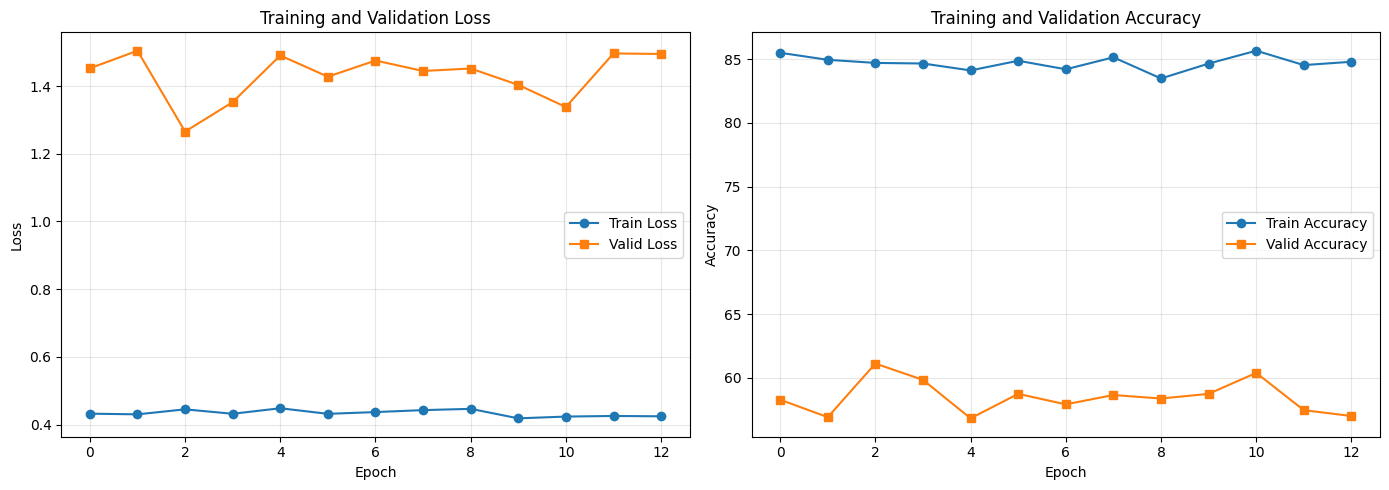

✓ Training history plotted and saved to 'cnn_training_history.png'


In [35]:
# ========== Plot Training History ==========
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(valid_losses, label='Valid Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accs, label='Train Accuracy', marker='o')
ax2.plot(valid_accs, label='Valid Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plotted and saved to 'cnn_training_history.png'")

## Final Evaluation on Test Set

In [36]:
from sklearn.metrics import classification_report

# Load best model and evaluate on test set
print("Loading best model for final evaluation...")

# Load best model
model.load_state_dict(torch.load('models/best_cnn_model.pth'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("=" * 70)
print("FINAL TEST SET RESULTS")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 70)

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
target_names = [idx2label[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))

print("\nEvaluation complete!")

Loading best model for final evaluation...
FINAL TEST SET RESULTS
Test Loss: 0.8558
Test Accuracy: 73.0000

Detailed Classification Report:
              precision    recall  f1-score   support

        ABBR     1.0000    0.4444    0.6154         9
        ENTY     0.8438    0.2872    0.4286        94
        DESC     0.7867    0.8551    0.8194       138
         HUM     0.8485    0.8615    0.8550        65
         LOC     0.7867    0.7284    0.7564        81
         NUM     0.5838    0.8938    0.7063       113

    accuracy                         0.7300       500
   macro avg     0.8082    0.6784    0.6968       500
weighted avg     0.7634    0.7300    0.7111       500


Evaluation complete!


## Hyperparameter Tuning and Regularization Experiments

This section demonstrates systematic experimental methodology:
1. Using validation set to evaluate performance at each epoch
2. Comparing different optimizers (SGD, Adam, RMSprop)
3. Tuning learning rates and batch sizes using validation accuracy
4. Applying regularization techniques to prevent overfitting
5. Implementing early stopping based on validation performance

### Summary of Initial Configuration

The baseline model was trained with:
- **Optimizer:** Adam with learning rate = 0.001
- **Batch Size:** 64
- **Regularization:** Dropout (0.5), Gradient Clipping (max_norm=1.0)
- **Early Stopping:** Patience = 5 epochs
- **Learning Rate Scheduler:** ReduceLROnPlateau

The following experiments explore alternative configurations and regularization techniques.

## 5. Experimental Analysis

### Experiment 1: Optimizer Comparison

This experiment compares three popular optimization algorithms:
- **SGD with Momentum:** Classic optimizer requiring careful tuning
- **Adam:** Adaptive learning rate optimizer, generally robust
- **RMSprop:** Effective for recurrent networks and sometimes CNNs

Each optimizer is evaluated using validation accuracy to determine the optimal choice.

In [45]:
"""
EXPERIMENT 1: Optimizer Comparison
=====================================
Test different optimizers with the same architecture and hyperparameters.
"""


def train_with_config(model_class, config, train_loader, valid_loader, device,
                      num_epochs=15, early_stop_patience=5, verbose=True):
    """
    Train a model with a specific configuration and return results.
    
    Args:
        model_class: Model class to instantiate
        config: Dictionary with hyperparameters
        train_loader: Training data loader
        valid_loader: Validation data loader
        device: Device to train on
        num_epochs: Maximum number of epochs
        early_stop_patience: Early stopping patience
        verbose: Whether to print progress
    
    Returns:
        Dictionary with training history and best validation accuracy
    """
    # Initialize model
    model = model_class(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_classes=NUM_CLASSES,
        kernel_sizes=config.get('kernel_sizes', [3, 4, 5]),
        num_filters=config.get('num_filters', 100),
        dropout=config.get('dropout', 0.5),
    ).to(device)

    # Register gradient masking hook for selective OOV training
    hook_fn = create_gradient_mask_hook(freeze_mask)
    hook_handle = model.embedding.weight.register_hook(hook_fn)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer_name = config.get('optimizer', 'Adam')
    lr = config.get('learning_rate', 0.001)

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'SGD':
        momentum = config.get('momentum', 0.9)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2,
        verbose=False
    )

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': [],
        'learning_rates': []
    }

    # Early stopping
    model_path = f"models/temp_best_model.pt"
    early_stopping = EarlyStopping(patience=early_stop_patience, verbose=verbose, path=model_path)
    best_valid_acc = 0

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Training with: {optimizer_name} (lr={lr}, batch_size={config.get('batch_size', 64)})")
        print(f"Regularization: Dropout={config.get('dropout', 0.5)}")
        print(f"{'=' * 70}\n")

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

        # Record metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        history['learning_rates'].append(optimizer.param_groups[0]['lr'])

        # Update learning rate
        scheduler.step(valid_acc)

        if verbose:
            print(f"Epoch {epoch + 1:2d}/{num_epochs} | "
                  f"Train: Loss={train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Valid: Loss={valid_loss:.4f} Acc={valid_acc:.4f} | "
                  f"LR={optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch + 1}")
            break

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Best Validation Accuracy: {best_valid_acc:.4f}")
        print(f"{'=' * 70}\n")

    # Clean up hook
    hook_handle.remove()

    # Load best model
    model.load_state_dict(torch.load(model_path))
    return {
        'model_state': model.state_dict(),
        'history': history,
        'best_valid_acc': best_valid_acc,
        'config': config
    }


print("✓ Training function with configuration support defined")

✓ Training function with configuration support defined


In [46]:
# ========== Run Optimizer Comparison ==========
print("🔬 EXPERIMENT 1: Comparing Optimizers\n")

# Define configurations for different optimizers
optimizer_configs = [
    {
        'name': 'Adam',
        'optimizer': 'Adam',
        'learning_rate': 0.001,
        'batch_size': 64,
        'dropout': 0.5
    },
    {
        'name': 'SGD_Momentum',
        'optimizer': 'SGD',
        'learning_rate': 0.01,  # SGD typically needs higher LR
        'momentum': 0.9,
        'batch_size': 64,
        'dropout': 0.5
    },
    {
        'name': 'RMSprop',
        'optimizer': 'RMSprop',
        'learning_rate': 0.001,
        'batch_size': 64,
        'dropout': 0.5
    }
]

# Store results
optimizer_results = {}

for config in optimizer_configs:
    print(f"\n{'=' * 70}")
    print(f"Testing: {config['name']}")
    print(f"{'=' * 70}")

    result = train_with_config(
        model_class=TextCNN,
        config=config,
        train_loader=train_loader,
        valid_loader=valid_loader,
        device=device,
        num_epochs=15,
        early_stop_patience=5,
        verbose=True
    )

    optimizer_results[config['name']] = result

print("\n" + "=" * 70)
print("📊 OPTIMIZER COMPARISON SUMMARY")
print("=" * 70)
for name, result in optimizer_results.items():
    print(f"{name:20s} | Best Valid Acc: {result['best_valid_acc']:.4f}")
print("=" * 70)

🔬 EXPERIMENT 1: Comparing Optimizers


Testing: Adam

Training with: Adam (lr=0.001, batch_size=64)
Regularization: Dropout=0.5

Epoch  1/15 | Train: Loss=1.4773 Acc=40.8004 | Valid: Loss=1.3601 Acc=51.9671 | LR=0.001000
Validation loss decreased (inf --> 1.360084). Saving model ...
Epoch  2/15 | Train: Loss=0.9405 Acc=65.0255 | Valid: Loss=1.2468 Acc=52.9735 | LR=0.001000
Validation loss decreased (1.360084 --> 1.246784). Saving model ...
Epoch  3/15 | Train: Loss=0.6304 Acc=76.9292 | Valid: Loss=1.3049 Acc=56.5416 | LR=0.001000
EarlyStopping counter: 1 out of 5
Epoch  4/15 | Train: Loss=0.5013 Acc=81.8846 | Valid: Loss=1.3855 Acc=58.3715 | LR=0.001000
EarlyStopping counter: 2 out of 5
Epoch  5/15 | Train: Loss=0.3778 Acc=86.3489 | Valid: Loss=1.2699 Acc=65.3248 | LR=0.001000
EarlyStopping counter: 3 out of 5
Epoch  6/15 | Train: Loss=0.3399 Acc=88.0134 | Valid: Loss=1.1575 Acc=69.1674 | LR=0.001000
Validation loss decreased (1.246784 --> 1.157530). Saving model ...
Epoch  7/15 | Trai

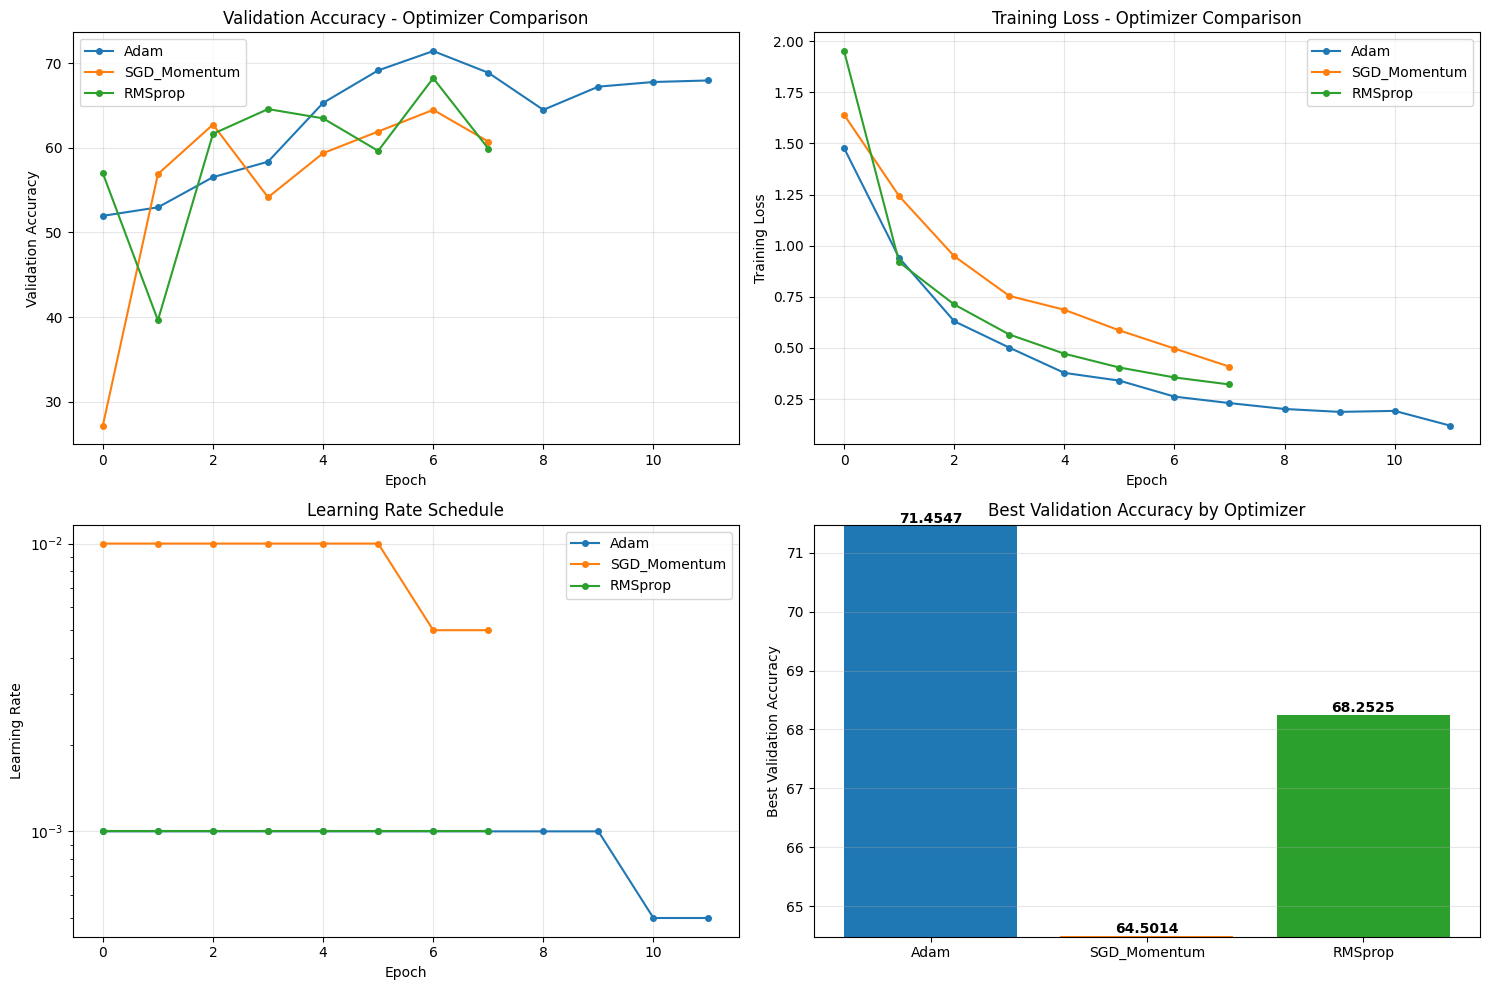

✓ Optimizer comparison plotted and saved to 'optimizer_comparison.png'


In [47]:
# ========== Visualize Optimizer Comparison ==========
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Validation Accuracy Comparison
ax = axes[0, 0]
for name, result in optimizer_results.items():
    ax.plot(result['history']['valid_acc'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy - Optimizer Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Training Loss Comparison
ax = axes[0, 1]
for name, result in optimizer_results.items():
    ax.plot(result['history']['train_loss'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title('Training Loss - Optimizer Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Learning Rate Schedule
ax = axes[1, 0]
for name, result in optimizer_results.items():
    ax.plot(result['history']['learning_rates'], label=name, marker='o', markersize=4)
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate')
ax.set_title('Learning Rate Schedule')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 4: Best Validation Accuracy Bar Chart
ax = axes[1, 1]
names = list(optimizer_results.keys())
best_accs = [optimizer_results[name]['best_valid_acc'] for name in names]
bars = ax.bar(names, best_accs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Best Validation Accuracy')
ax.set_title('Best Validation Accuracy by Optimizer')
ax.set_ylim([min(best_accs) - 0.02, max(best_accs) + 0.02])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, best_accs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/optimizer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Optimizer comparison plotted and saved to 'optimizer_comparison.png'")

### Experiment 2: Batch Size and Learning Rate Tuning

Batch size and learning rate are closely related hyperparameters:
- **Smaller batches:** Introduce more noise in gradients, may require lower learning rates
- **Larger batches:** Provide more stable gradients, can utilize higher learning rates

This experiment tests different combinations using grid search evaluated on the validation set.

In [48]:
# ========== Batch Size and Learning Rate Grid Search ==========
print("🔬 EXPERIMENT 2: Batch Size & Learning Rate Tuning\n")

# Grid search parameters
batch_sizes = [32, 64, 128]
learning_rates = [0.0005, 0.001, 0.002]

# Store results
grid_search_results = {}

# Find the best optimizer from previous experiment
best_optimizer = max(optimizer_results.items(), key=lambda x: x[1]['best_valid_acc'])[0]
print(f"Using best optimizer from Experiment 1: {best_optimizer}\n")

# Get optimizer config
optimizer_config = next(c for c in optimizer_configs if c['name'] == best_optimizer)

for batch_size in batch_sizes:
    # Create new data loaders with different batch size
    temp_train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, collate_fn=collate_batch)
    temp_valid_loader = DataLoader(valid_dataset, batch_size=batch_size,
                                   shuffle=False, collate_fn=collate_batch)

    for lr in learning_rates:
        config_name = f"BS{batch_size}_LR{lr}"
        print(f"\n{'=' * 70}")
        print(f"Testing: Batch Size={batch_size}, Learning Rate={lr}")
        print(f"{'=' * 70}")

        config = {
            'optimizer': optimizer_config['optimizer'],
            'learning_rate': lr,
            'batch_size': batch_size,
            'dropout': 0.5,
            'kernel_sizes': [3, 4, 5],
            'num_filters': 100
        }

        if optimizer_config['optimizer'] == 'SGD':
            config['momentum'] = optimizer_config.get('momentum', 0.9)

        result = train_with_config(
            model_class=TextCNN,
            config=config,
            train_loader=temp_train_loader,
            valid_loader=temp_valid_loader,
            device=device,
            num_epochs=15,
            early_stop_patience=5,
            verbose=False  # Less verbose for grid search
        )

        grid_search_results[config_name] = result
        print(f"✓ Best Valid Acc: {result['best_valid_acc']:.4f}")

print("\n" + "=" * 70)
print("📊 GRID SEARCH RESULTS")
print("=" * 70)
print(f"{'Configuration':<25} {'Best Valid Acc':>15}")
print("-" * 70)
for config_name, result in sorted(grid_search_results.items(),
                                  key=lambda x: x[1]['best_valid_acc'],
                                  reverse=True):
    print(f"{config_name:<25} {result['best_valid_acc']:>15.4f}")
print("=" * 70)

# Find best configuration
best_config_name = max(grid_search_results.items(),
                       key=lambda x: x[1]['best_valid_acc'])[0]
best_config_result = grid_search_results[best_config_name]

print(f"\n🏆 BEST CONFIGURATION: {best_config_name}")
print(f"   Best Validation Accuracy: {best_config_result['best_valid_acc']:.4f}")
print(f"   Configuration: {best_config_result['config']}")

🔬 EXPERIMENT 2: Batch Size & Learning Rate Tuning

Using best optimizer from Experiment 1: Adam


Testing: Batch Size=32, Learning Rate=0.0005
✓ Best Valid Acc: 72.1866

Testing: Batch Size=32, Learning Rate=0.001
✓ Best Valid Acc: 69.8994

Testing: Batch Size=32, Learning Rate=0.002
✓ Best Valid Acc: 66.9716

Testing: Batch Size=64, Learning Rate=0.0005
✓ Best Valid Acc: 66.7887

Testing: Batch Size=64, Learning Rate=0.001
✓ Best Valid Acc: 71.8207

Testing: Batch Size=64, Learning Rate=0.002
✓ Best Valid Acc: 62.8545

Testing: Batch Size=128, Learning Rate=0.0005
✓ Best Valid Acc: 70.6313

Testing: Batch Size=128, Learning Rate=0.001
✓ Best Valid Acc: 73.8335

Testing: Batch Size=128, Learning Rate=0.002
✓ Best Valid Acc: 69.2589

📊 GRID SEARCH RESULTS
Configuration              Best Valid Acc
----------------------------------------------------------------------
BS128_LR0.001                     73.8335
BS32_LR0.0005                     72.1866
BS64_LR0.001                      71.8

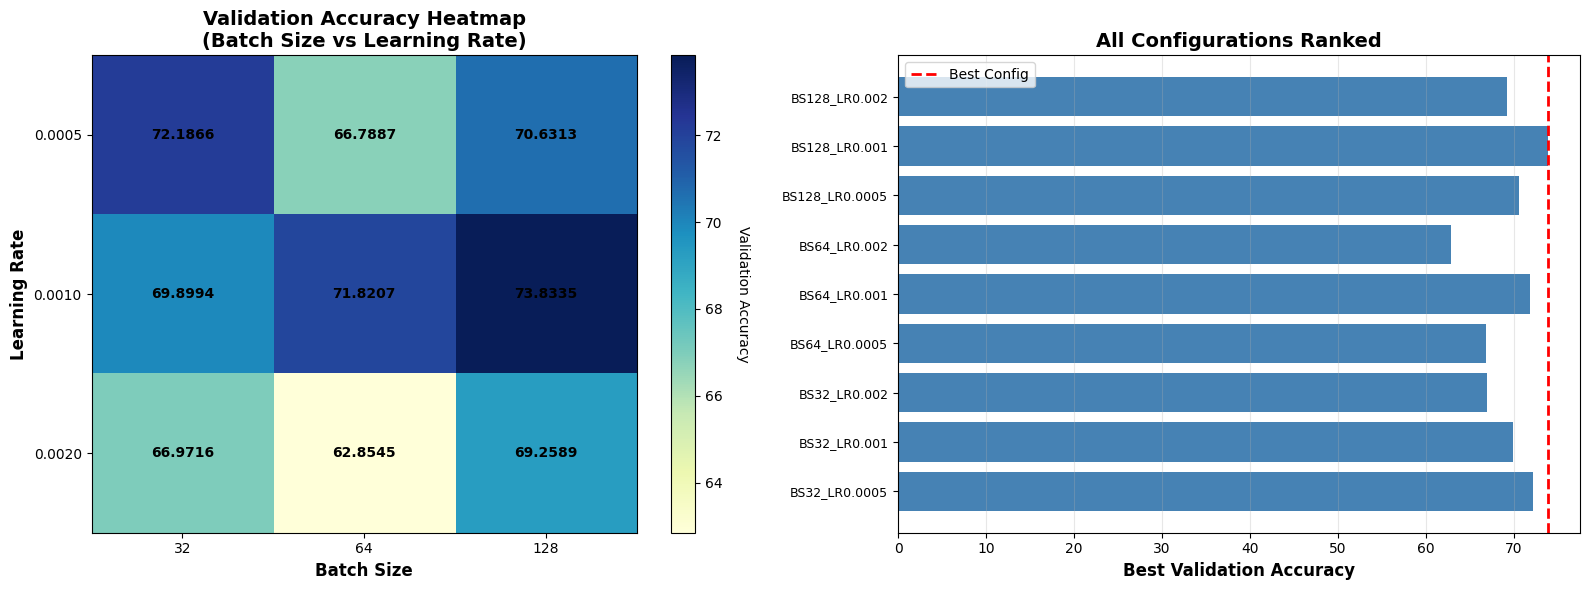

✓ Grid search results plotted and saved to 'grid_search_results.png'


In [49]:
# ========== Visualize Grid Search Results ==========
import numpy as np

# Create heatmap data
batch_size_labels = [str(bs) for bs in batch_sizes]
lr_labels = [f'{lr:.4f}' for lr in learning_rates]

# Create matrix for heatmap
heatmap_data = np.zeros((len(learning_rates), len(batch_sizes)))

for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        config_name = f"BS{bs}_LR{lr}"
        heatmap_data[i, j] = grid_search_results[config_name]['best_valid_acc']

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
im = ax1.imshow(heatmap_data, cmap='YlGnBu', aspect='auto')
ax1.set_xticks(np.arange(len(batch_sizes)))
ax1.set_yticks(np.arange(len(learning_rates)))
ax1.set_xticklabels(batch_size_labels)
ax1.set_yticklabels(lr_labels)
ax1.set_xlabel('Batch Size', fontsize=12, fontweight='bold')
ax1.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
ax1.set_title('Validation Accuracy Heatmap\n(Batch Size vs Learning Rate)',
              fontsize=14, fontweight='bold')

# Add text annotations
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        text = ax1.text(j, i, f'{heatmap_data[i, j]:.4f}',
                        ha="center", va="center", color="black", fontsize=10, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Validation Accuracy', rotation=270, labelpad=20)

# Bar chart of all configurations
ax2.barh(range(len(grid_search_results)),
         [r['best_valid_acc'] for r in grid_search_results.values()],
         color='steelblue')
ax2.set_yticks(range(len(grid_search_results)))
ax2.set_yticklabels(list(grid_search_results.keys()), fontsize=9)
ax2.set_xlabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('All Configurations Ranked', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=max([r['best_valid_acc'] for r in grid_search_results.values()]),
            color='red', linestyle='--', linewidth=2, label='Best Config')
ax2.legend()

plt.tight_layout()
plt.savefig('results/grid_search_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Grid search results plotted and saved to 'grid_search_results.png'")

### Experiment 3: Regularization Techniques

This experiment tests various regularization strategies to prevent overfitting:

**Regularization Techniques Evaluated:**

1. **Dropout Variations**
   - Different dropout rates (0.3, 0.5, 0.7)
   - Dropout placement (after embedding, after convolution, etc.)

2. **L2 Regularization (Weight Decay)**
   - Adding weight decay to optimizer parameters

3. **Gradient Clipping**
   - Testing different max_norm values (0.5, 1.0, 5.0)

4. **Batch Normalization**
   - Adding batch normalization layers after convolutions

5. **Early Stopping**
   - Already implemented with configurable patience values

In [50]:
# ========== Enhanced CNN with Batch Normalization ==========
class TextCNN_BN(nn.Module):
    """
    CNN with Batch Normalization for better regularization.
    """

    def __init__(self, vocab_size, embed_dim, num_classes,
                 kernel_sizes=[3, 4, 5], num_filters=100, dropout=0.5):
        super(TextCNN_BN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Convolutional layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters,
                      kernel_size=(k, embed_dim))
            for k in kernel_sizes
        ])

        # Batch normalization layers (one for each conv)
        self.batch_norms = nn.ModuleList([
            nn.BatchNorm1d(num_filters)
            for _ in kernel_sizes
        ])

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, text, lengths=None):
        # Embedding
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)

        # Apply convolutions with batch norm
        conved_list = []
        for conv, bn in zip(self.convs, self.batch_norms):
            # Convolution + squeeze
            conved = torch.relu(conv(embedded)).squeeze(3)
            # Batch normalization
            conved = bn(conved)
            conved_list.append(conved)

        # Max pooling
        pooled = [torch.max(conv, dim=2)[0] for conv in conved_list]

        # Concatenate
        cat = torch.cat(pooled, dim=1)

        # Dropout
        cat = self.dropout(cat)

        # FC layer
        logits = self.fc(cat)

        return logits


print("✓ TextCNN with Batch Normalization defined")

✓ TextCNN with Batch Normalization defined


In [51]:
# ========== Modified Training Function with Weight Decay and Gradient Clipping ==========
def train_with_regularization(model_class, config, train_loader, valid_loader, device,
                              num_epochs=15, early_stop_patience=5, verbose=True):
    """
    Enhanced training function with additional regularization options.
    """
    # Initialize model
    model = model_class(
        vocab_size=VOCAB_SIZE,
        embed_dim=EMBED_DIM,
        num_classes=NUM_CLASSES,
        kernel_sizes=config.get('kernel_sizes', [3, 4, 5]),
        num_filters=config.get('num_filters', 100),
        dropout=config.get('dropout', 0.5)
    ).to(device)

    # Register gradient masking hook
    hook_fn = create_gradient_mask_hook(freeze_mask)
    hook_handle = model.embedding.weight.register_hook(hook_fn)

    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay (L2 regularization)
    optimizer_name = config.get('optimizer', 'Adam')
    lr = config.get('learning_rate', 0.001)
    weight_decay = config.get('weight_decay', 0.0)  # L2 regularization

    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        momentum = config.get('momentum', 0.9)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,
                                    momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2,
        verbose=False
    )

    # Get gradient clipping max norm
    grad_clip = config.get('grad_clip', 1.0)

    history = {
        'train_loss': [], 'train_acc': [],
        'valid_loss': [], 'valid_acc': []
    }

    # Early stopping
    model_path = f"models/temp_best_model.pt"
    early_stopping = EarlyStopping(patience=early_stop_patience, verbose=verbose, path=model_path)
    best_valid_acc = 0

    if verbose:
        print(f"\n{'=' * 70}")
        print(f"Config: {optimizer_name}(lr={lr}, wd={weight_decay}), "
              f"dropout={config.get('dropout', 0.5)}, grad_clip={grad_clip}")
        print(f"{'=' * 70}\n")

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for texts, labels, lengths in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(texts, lengths)
            loss = criterion(logits, labels)
            loss.backward()

            # Gradient clipping
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(all_labels, all_preds)

        # Validation
        valid_loss, valid_acc, _, _ = evaluate(model, valid_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        scheduler.step(valid_acc)

        if verbose:
            print(f"Epoch {epoch + 1:2d}/{num_epochs} | "
                  f"Train: Loss={train_loss:.4f} Acc={train_acc:.4f} | "
                  f"Valid: Loss={valid_loss:.4f} Acc={valid_acc:.4f}")

        # Early stopping
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            if verbose:
                print(f"\nEarly stopping at epoch {epoch + 1}")
            break

    if verbose:
        print(f"\nBest Validation Accuracy: {best_valid_acc:.4f}\n")

    hook_handle.remove()

    #load best model state
    model.load_state_dict(torch.load(model_path))
    return {
        'model_state': model.state_dict(),
        'history': history,
        'best_valid_acc': best_valid_acc,
        'config': config
    }


print("✓ Enhanced training function with regularization defined")

✓ Enhanced training function with regularization defined


In [52]:
# ========== Test Regularization Techniques ==========
print("🔬 EXPERIMENT 3: Regularization Techniques\n")

# Use best config from previous experiments
best_bs = int(best_config_name.split('_')[0].replace('BS', ''))
best_lr = float(best_config_name.split('_')[1].replace('LR', ''))

# Create data loaders with best batch size
best_train_loader = DataLoader(train_dataset, batch_size=best_bs,
                               shuffle=True, collate_fn=collate_batch)
best_valid_loader = DataLoader(valid_dataset, batch_size=best_bs,
                               shuffle=False, collate_fn=collate_batch)

print(f"Using best batch size: {best_bs}, best learning rate: {best_lr}\n")

# Define regularization configurations
regularization_configs = [
    {
        'name': 'Baseline',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'High_Dropout',
        'model': TextCNN,
        'dropout': 0.7,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'Low_Dropout',
        'model': TextCNN,
        'dropout': 0.3,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'L2_WeightDecay',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'grad_clip': 1.0
    },
    {
        'name': 'L2_High',
        'model': TextCNN,
        'dropout': 0.5,
        'weight_decay': 1e-3,
        'grad_clip': 1.0
    },
    {
        'name': 'BatchNorm',
        'model': TextCNN_BN,
        'dropout': 0.5,
        'weight_decay': 0.0,
        'grad_clip': 1.0
    },
    {
        'name': 'BatchNorm_L2',
        'model': TextCNN_BN,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'grad_clip': 1.0
    },
    {
        'name': 'Aggressive_Reg',
        'model': TextCNN_BN,
        'dropout': 0.6,
        'weight_decay': 1e-4,
        'grad_clip': 0.5
    }
]

regularization_results = {}

for reg_config in regularization_configs:
    print(f"\n{'=' * 70}")
    print(f"Testing: {reg_config['name']}")
    print(f"{'=' * 70}")

    config = {
        'optimizer': optimizer_config['optimizer'],
        'learning_rate': best_lr,
        'batch_size': best_bs,
        'dropout': reg_config['dropout'],
        'weight_decay': reg_config['weight_decay'],
        'grad_clip': reg_config['grad_clip'],
        'kernel_sizes': [3, 4, 5],
        'num_filters': 100
    }

    if optimizer_config['optimizer'] == 'SGD':
        config['momentum'] = optimizer_config.get('momentum', 0.9)

    result = train_with_regularization(
        model_class=reg_config['model'],
        config=config,
        train_loader=best_train_loader,
        valid_loader=best_valid_loader,
        device=device,
        num_epochs=15,
        early_stop_patience=5,
        verbose=True
    )

    regularization_results[reg_config['name']] = result

print("\n" + "=" * 70)
print("📊 REGULARIZATION COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Configuration':<25} {'Best Valid Acc':>15} {'Train-Valid Gap':>15}")
print("-" * 70)
for name, result in sorted(regularization_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True):
    final_train_acc = result['history']['train_acc'][-1]
    gap = final_train_acc - result['best_valid_acc']
    print(f"{name:<25} {result['best_valid_acc']:>15.4f} {gap:>15.4f}")
print("=" * 70)

best_reg = max(regularization_results.items(), key=lambda x: x[1]['best_valid_acc'])[0]
print(f"\n🏆 Best Regularization: {best_reg}")
print(f"   Validation Accuracy: {regularization_results[best_reg]['best_valid_acc']:.4f}")

🔬 EXPERIMENT 3: Regularization Techniques

Using best batch size: 128, best learning rate: 0.001


Testing: Baseline

Config: Adam(lr=0.001, wd=0.0), dropout=0.5, grad_clip=1.0

Epoch  1/15 | Train: Loss=1.3902 Acc=0.4439 | Valid: Loss=1.1172 Acc=59.6523
Validation loss decreased (inf --> 1.117204). Saving model ...
Epoch  2/15 | Train: Loss=0.8074 Acc=0.6963 | Valid: Loss=0.8699 Acc=69.8079
Validation loss decreased (1.117204 --> 0.869929). Saving model ...
Epoch  3/15 | Train: Loss=0.5576 Acc=0.7997 | Valid: Loss=1.3064 Acc=60.3843
EarlyStopping counter: 1 out of 5
Epoch  4/15 | Train: Loss=0.4069 Acc=0.8541 | Valid: Loss=1.3528 Acc=65.0503
EarlyStopping counter: 2 out of 5
Epoch  5/15 | Train: Loss=0.3369 Acc=0.8846 | Valid: Loss=2.2073 Acc=53.9799
EarlyStopping counter: 3 out of 5
Epoch  6/15 | Train: Loss=0.2583 Acc=0.9147 | Valid: Loss=1.6213 Acc=66.8801
EarlyStopping counter: 4 out of 5
Epoch  7/15 | Train: Loss=0.1932 Acc=0.9309 | Valid: Loss=1.7737 Acc=66.4227
EarlyStopping co

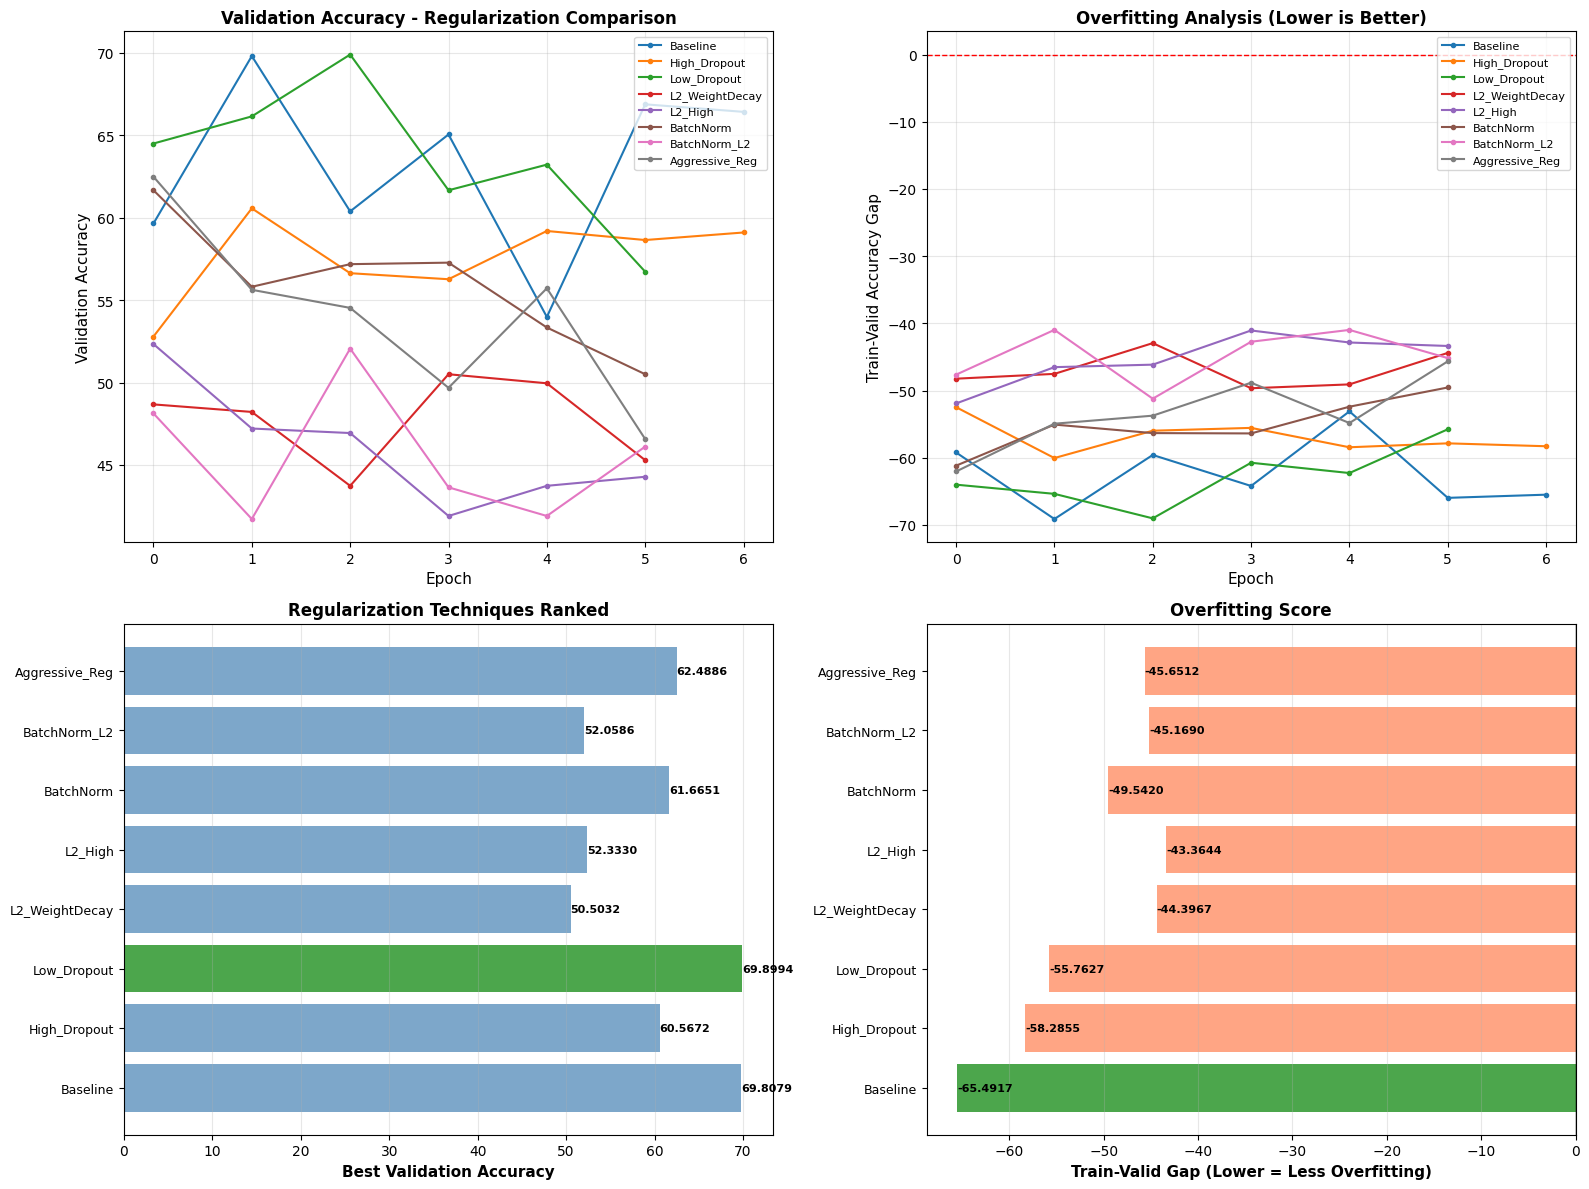

✓ Regularization comparison plotted and saved to 'regularization_comparison.png'


In [53]:
# ========== Visualize Regularization Results ==========
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Validation Accuracy Comparison
ax = axes[0, 0]
for name, result in regularization_results.items():
    ax.plot(result['history']['valid_acc'], label=name, marker='o', markersize=3)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Validation Accuracy', fontsize=11)
ax.set_title('Validation Accuracy - Regularization Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)

# Plot 2: Train vs Valid Accuracy (Overfitting Analysis)
ax = axes[0, 1]
for name, result in regularization_results.items():
    train_accs = result['history']['train_acc']
    valid_accs = result['history']['valid_acc']
    gap = [t - v for t, v in zip(train_accs, valid_accs)]
    ax.plot(gap, label=name, marker='o', markersize=3)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Train-Valid Accuracy Gap', fontsize=11)
ax.set_title('Overfitting Analysis (Lower is Better)', fontsize=12, fontweight='bold')
ax.legend(fontsize=8, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Plot 3: Best Validation Accuracy Bar Chart
ax = axes[1, 0]
names = list(regularization_results.keys())
best_accs = [regularization_results[name]['best_valid_acc'] for name in names]
colors = ['green' if name == best_reg else 'steelblue' for name in names]
bars = ax.barh(range(len(names)), best_accs, color=colors, alpha=0.7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Best Validation Accuracy', fontsize=11, fontweight='bold')
ax.set_title('Regularization Techniques Ranked', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, best_accs)):
    ax.text(acc + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{acc:.4f}', va='center', fontsize=8, fontweight='bold')

# Plot 4: Overfitting Score (Final Train-Valid Gap)
ax = axes[1, 1]
overfitting_scores = []
for name in names:
    result = regularization_results[name]
    final_train = result['history']['train_acc'][-1]
    final_valid = result['history']['valid_acc'][-1]
    gap = final_train - final_valid
    overfitting_scores.append(gap)

colors_over = ['green' if gap == min(overfitting_scores) else 'coral' for gap in overfitting_scores]
bars = ax.barh(range(len(names)), overfitting_scores, color=colors_over, alpha=0.7)
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names, fontsize=9)
ax.set_xlabel('Train-Valid Gap (Lower = Less Overfitting)', fontsize=11, fontweight='bold')
ax.set_title('Overfitting Score', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Add value labels
for i, (bar, gap) in enumerate(zip(bars, overfitting_scores)):
    ax.text(gap + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{gap:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('results/regularization_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Regularization comparison plotted and saved to 'regularization_comparison.png'")

### Training Final Model with Best Configuration

In [54]:
# ========== Train Final Model with Best Configuration ==========
print("🏆 FINAL MODEL TRAINING")
print("=" * 70)

# Get best regularization config
best_reg_result = regularization_results[best_reg]
final_config = best_reg_result['config'].copy()

# Find which model class to use
best_reg_config = next(rc for rc in regularization_configs if rc['name'] == best_reg)
final_model_class = best_reg_config['model']

print(f"Best Configuration Found:")
print(f"  Optimizer: {final_config['optimizer']}")
print(f"  Learning Rate: {final_config['learning_rate']}")
print(f"  Batch Size: {final_config['batch_size']}")
print(f"  Dropout: {final_config['dropout']}")
print(f"  Weight Decay: {final_config['weight_decay']}")
print(f"  Gradient Clipping: {final_config['grad_clip']}")
print(f"  Model Architecture: {final_model_class.__name__}")
print(f"  Kernel Sizes: {final_config['kernel_sizes']}")
print(f"  Num Filters: {final_config['num_filters']}")
print("=" * 70)

# Train final model with more epochs
print("\nTraining final model with extended epochs...")

final_result = train_with_regularization(
    model_class=final_model_class,
    config=final_config,
    train_loader=best_train_loader,
    valid_loader=best_valid_loader,
    device=device,
    num_epochs=30,  # More epochs for final model
    early_stop_patience=7,  # More patience
    verbose=True
)

print("\n" + "=" * 70)
print("FINAL MODEL RESULTS")
print("=" * 70)
print(f"Best Validation Accuracy: {final_result['best_valid_acc']:.4f}")
print("=" * 70)

# Save the final model
final_model = final_model_class(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_classes=NUM_CLASSES,
    kernel_sizes=final_config['kernel_sizes'],
    num_filters=final_config['num_filters'],
    dropout=final_config['dropout']
).to(device)

final_model.load_state_dict(final_result['model_state'])
torch.save(final_model.state_dict(), 'models/final_best_cnn_model.pth')
print("\n✓ Final model saved to 'final_best_cnn_model.pth'")

🏆 FINAL MODEL TRAINING
Best Configuration Found:
  Optimizer: Adam
  Learning Rate: 0.001
  Batch Size: 128
  Dropout: 0.3
  Weight Decay: 0.0
  Gradient Clipping: 1.0
  Model Architecture: TextCNN
  Kernel Sizes: [3, 4, 5]
  Num Filters: 100

Training final model with extended epochs...

Config: Adam(lr=0.001, wd=0.0), dropout=0.3, grad_clip=1.0

Epoch  1/30 | Train: Loss=1.2086 Acc=0.5180 | Valid: Loss=1.0173 Acc=63.8609
Validation loss decreased (inf --> 1.017280). Saving model ...
Epoch  2/30 | Train: Loss=0.5811 Acc=0.8011 | Valid: Loss=1.2034 Acc=67.3376
EarlyStopping counter: 1 out of 7
Epoch  3/30 | Train: Loss=0.3420 Acc=0.8809 | Valid: Loss=1.7683 Acc=58.0970
EarlyStopping counter: 2 out of 7
Epoch  4/30 | Train: Loss=0.2184 Acc=0.9257 | Valid: Loss=1.7180 Acc=61.2992
EarlyStopping counter: 3 out of 7
Epoch  5/30 | Train: Loss=0.1643 Acc=0.9424 | Valid: Loss=3.1845 Acc=53.5224
EarlyStopping counter: 4 out of 7
Epoch  6/30 | Train: Loss=0.1034 Acc=0.9663 | Valid: Loss=2.2291 A

In [55]:
# ========== Evaluate Final Model on Test Set ==========
print("Evaluating final model on test set...")

# Create test loader with best batch size
final_test_loader = DataLoader(test_dataset, batch_size=final_config['batch_size'],
                               shuffle=False, collate_fn=collate_batch)

criterion = nn.CrossEntropyLoss()

# Evaluate
test_loss, test_acc, test_preds, test_labels = evaluate(
    final_model, final_test_loader, criterion, device
)

print("\n" + "=" * 70)
print("FINAL MODEL - TEST SET EVALUATION")
print("=" * 70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("=" * 70)

# Detailed classification report
print("\nDetailed Classification Report:")
print("=" * 70)
target_names = [idx2label[i] for i in range(NUM_CLASSES)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))

print("\n✓ Final evaluation complete!")

Evaluating final model on test set...

FINAL MODEL - TEST SET EVALUATION
Test Loss: 0.8782
Test Accuracy: 73.0000

Detailed Classification Report:
              precision    recall  f1-score   support

        ABBR     0.0000    0.0000    0.0000         9
        ENTY     0.7647    0.4149    0.5379        94
        DESC     0.7901    0.9275    0.8533       138
         HUM     0.8571    0.8308    0.8438        65
         LOC     0.6111    0.9506    0.7440        81
         NUM     0.6837    0.5929    0.6351       113

    accuracy                         0.7300       500
   macro avg     0.6178    0.6195    0.6023       500
weighted avg     0.7268    0.7300    0.7104       500


✓ Final evaluation complete!


C:\Users\avane\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\avane\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\avane\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Final Test Set Evaluation

In [56]:
# Comprehensive Experiment Summary
import pandas as pd

print("\n" + "=" * 90)
print(" " * 30 + "EXPERIMENT SUMMARY")
print("=" * 90)

# Experiment 1: Optimizer Comparison
print("\nEXPERIMENT 1: Optimizer Comparison")
print("-" * 90)
opt_data = []
for name, result in optimizer_results.items():
    opt_data.append({
        'Optimizer': name,
        'Best Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Final Train Acc': f"{result['history']['train_acc'][-1]:.4f}",
        'Epochs Trained': len(result['history']['train_acc'])
    })
opt_df = pd.DataFrame(opt_data)
print(opt_df.to_string(index=False))

# Experiment 2: Grid Search
print("\n\nEXPERIMENT 2: Batch Size & Learning Rate Tuning")
print("-" * 90)
grid_data = []
for name, result in sorted(grid_search_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True)[:5]:  # Top 5
    config = result['config']
    grid_data.append({
        'Config': name,
        'Best Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Batch Size': config['batch_size'],
        'Learning Rate': config['learning_rate']
    })
grid_df = pd.DataFrame(grid_data)
print("Top 5 Configurations:")
print(grid_df.to_string(index=False))

# Experiment 3: Regularization
print("\n\nEXPERIMENT 3: Regularization Techniques")
print("-" * 90)
reg_data = []
for name, result in sorted(regularization_results.items(),
                           key=lambda x: x[1]['best_valid_acc'],
                           reverse=True):
    config = result['config']
    final_train = result['history']['train_acc'][-1]
    gap = final_train - result['best_valid_acc']
    reg_data.append({
        'Technique': name,
        'Valid Acc': f"{result['best_valid_acc']:.4f}",
        'Train-Valid Gap': f"{gap:.4f}",
        'Dropout': config['dropout'],
        'Weight Decay': config['weight_decay']
    })
reg_df = pd.DataFrame(reg_data)
print(reg_df.to_string(index=False))

# Final Summary
print("\n\n" + "=" * 90)
print(" " * 35 + "FINAL RESULTS")
print("=" * 90)
print(f"\nBest Configuration Found:")
print(f"   - Optimizer: {final_config['optimizer']}")
print(f"   - Learning Rate: {final_config['learning_rate']}")
print(f"   - Batch Size: {final_config['batch_size']}")
print(f"   - Dropout: {final_config['dropout']}")
print(f"   - Weight Decay: {final_config['weight_decay']}")
print(f"   - Gradient Clipping: {final_config['grad_clip']}")
print(f"   - Model: {final_model_class.__name__}")

print(f"\nPerformance Metrics:")
print(f"   - Best Validation Accuracy: {final_result['best_valid_acc']:.4f}")
print(f"   - Test Accuracy: {test_acc:.4f}")
print(f"   - Total Epochs Trained: {len(final_result['history']['train_acc'])}")

print("\n" + "=" * 90)
print("\nAll experiments completed successfully!")


                              EXPERIMENT SUMMARY

EXPERIMENT 1: Optimizer Comparison
------------------------------------------------------------------------------------------
   Optimizer Best Valid Acc Final Train Acc  Epochs Trained
        Adam        71.4547         96.0045              12
SGD_Momentum        64.5014         85.2200               8
     RMSprop        68.2525         88.5523               8


EXPERIMENT 2: Batch Size & Learning Rate Tuning
------------------------------------------------------------------------------------------
Top 5 Configurations:
        Config Best Valid Acc  Batch Size  Learning Rate
 BS128_LR0.001        73.8335         128         0.0010
 BS32_LR0.0005        72.1866          32         0.0005
  BS64_LR0.001        71.8207          64         0.0010
BS128_LR0.0005        70.6313         128         0.0005
  BS32_LR0.001        69.8994          32         0.0010


EXPERIMENT 3: Regularization Techniques
------------------------------------

## Understanding Early Stopping

### Definition

Early stopping is a regularization technique that prevents overfitting by halting training when the model's performance on the validation set stops improving.

### Implementation in This Notebook

```python
# Configuration
EARLY_STOP_PATIENCE = 5  # Number of epochs to wait

# Tracking variables
best_valid_acc = 0       # Best validation accuracy observed
patience_counter = 0     # Epochs without improvement
```

### Algorithm

At each epoch:

1. **Train the model** on the training set
2. **Evaluate on validation set** to obtain validation accuracy
3. **Compare with best accuracy:**
   
   **If validation accuracy improves** (exceeds best_valid_acc):
   - Update best_valid_acc to current accuracy
   - Reset patience_counter = 0
   - Save the model (this is the best version)
   - Continue training
   
   **If validation accuracy does not improve:**
   - Increment patience_counter += 1
   - Display: "Patience: X/5"
   - **If** patience_counter >= EARLY_STOP_PATIENCE:
     - Stop training (early stopping triggered)
     - Model has likely begun overfitting
   - **Otherwise:**
     - Continue training (allow more opportunities)

### Example Training Sequence

```
Epoch  1/20 | Valid Acc: 0.8500
  New best model saved! (Valid Acc: 0.8500)

Epoch  2/20 | Valid Acc: 0.8700
  New best model saved! (Valid Acc: 0.8700)

Epoch  3/20 | Valid Acc: 0.8800
  New best model saved! (Valid Acc: 0.8800)

Epoch  4/20 | Valid Acc: 0.8750  <- Worse than 0.8800
  Patience: 1/5                   <- Counter starts

Epoch  5/20 | Valid Acc: 0.8720  <- Still worse
  Patience: 2/5                   <- Counter increases

Epoch  6/20 | Valid Acc: 0.8780  <- Still worse
  Patience: 3/5

Epoch  7/20 | Valid Acc: 0.8760
  Patience: 4/5

Epoch  8/20 | Valid Acc: 0.8740
  Patience: 5/5                   <- Reached limit

Early stopping triggered at epoch 9  <- Training stops

Best model: Epoch 3 with 0.8800 accuracy
```

### Rationale for Early Stopping

**1. Prevents Overfitting**
- After a certain point, model begins memorizing training data
- Validation accuracy plateaus or decreases
- Early stopping detects this and halts training

**2. Computational Efficiency**
- Avoids unnecessary training when model has converged
- Automatically stops without requiring full epoch budget

**3. Automatic Regularization**
- Complements other regularization techniques (dropout, weight decay)
- Requires no manual intervention

**4. Guarantees Optimal Model**
- Saves model at peak performance
- Returns best version rather than final version

### Tuning the Patience Parameter

**Patience = 5** (current setting):
- Waits 5 consecutive epochs without improvement
- Balanced approach suitable for most datasets
- Recommended for general use

**Different Patience Values:**

| Patience | Behavior | Best Application |
|----------|----------|-----------------|
| 2-3 | Aggressive early stopping | Small datasets, quick experiments |
| 5-7 | Balanced (recommended) | General use, medium datasets |
| 10+ | Very patient | Large datasets, slow convergence |

### Visual Representation

```
Validation Accuracy over Epochs:

 0.90 |                 * Best model saved here
      |               / \
 0.85 |             /     \
      |           /         \ \ \ <- Decreasing
 0.80 |         /             \ \ \
      |       /                   \
 0.75 |     /                       \
      |   /                           STOP
 0.70 | /                             (Patience reached)
      +--+--+--+--+--+--+--+--+--+--
        1  2  3  4  5  6  7  8  9 10
                    +---------+
                    Patience counter:
                    1  2  3  4  5
```

### Integration with Other Components

**1. Learning Rate Scheduler (ReduceLROnPlateau)**
   - Reduces learning rate when validation accuracy plateaus
   - Provides opportunity for fine-tuning before early stopping

**2. Model Checkpointing**
   - Automatically saves best model weights
   - Ensures optimal weights are preserved

**3. Validation Set**
   - Provides unbiased performance metric
   - Enables detection of overfitting

### Key Insight

Early stopping directly implements the requirement: "Train the model until the accuracy score on the validation set is not increasing for a few epochs." The patience parameter (5 epochs) defines "a few epochs" and automatically terminates training when this criterion is met.